In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from datetime import datetime

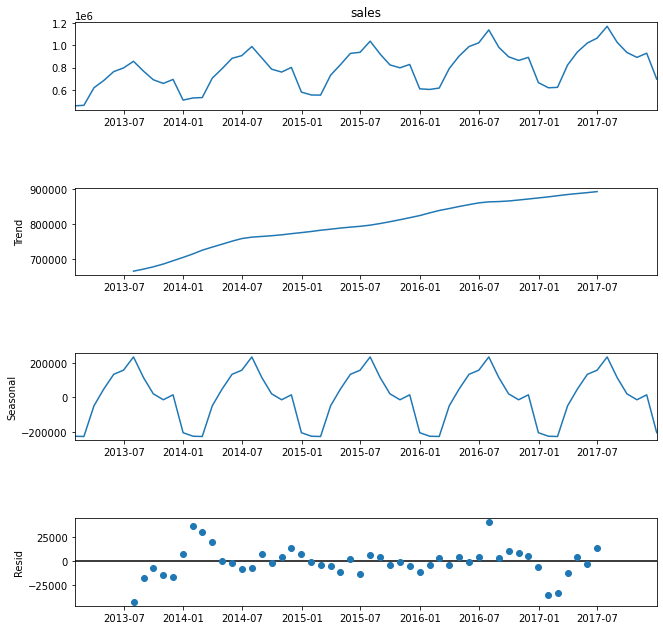

In [40]:
df = pd.read_csv("ARIMA_Dataset/train.csv")

# string 형태의 date 필드를 datetime 형태로 변환
df['date'] =  pd.to_datetime(df['date'])

# date 필드를 index로 설정
df = df.set_index('date')

# 빠르게 테스트 해 보기 위해 월별로 아이템 판매 예측
salesbymonth = df.sales.resample('M').sum()

# 데이터를 시즌별로 분해해서 살펴 봄
decomposition = sm.tsa.seasonal_decompose(salesbymonth, model='additive')
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

- Trend 그래프에서 꾸준한 상승 확인
- Seasonal 그래프에서 Seasonal한 특성이 있는것을 확인

C:\Users\rlawo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


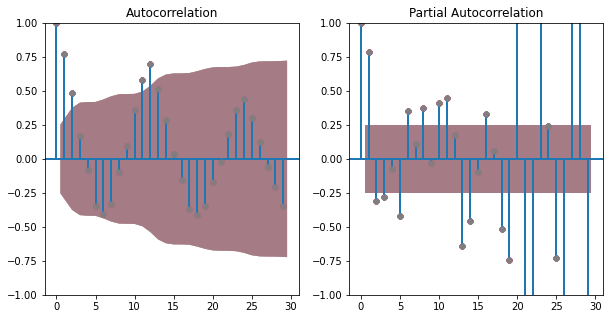

In [120]:
# ACF, P_ACF 그래프 확인
sm.graphics.tsa.plot_acf(salesbymonth.values, lags = 29, ax = ax[0])
sm.graphics.tsa.plot_pacf(salesbymonth.values, lags = 29, ax = ax[1])

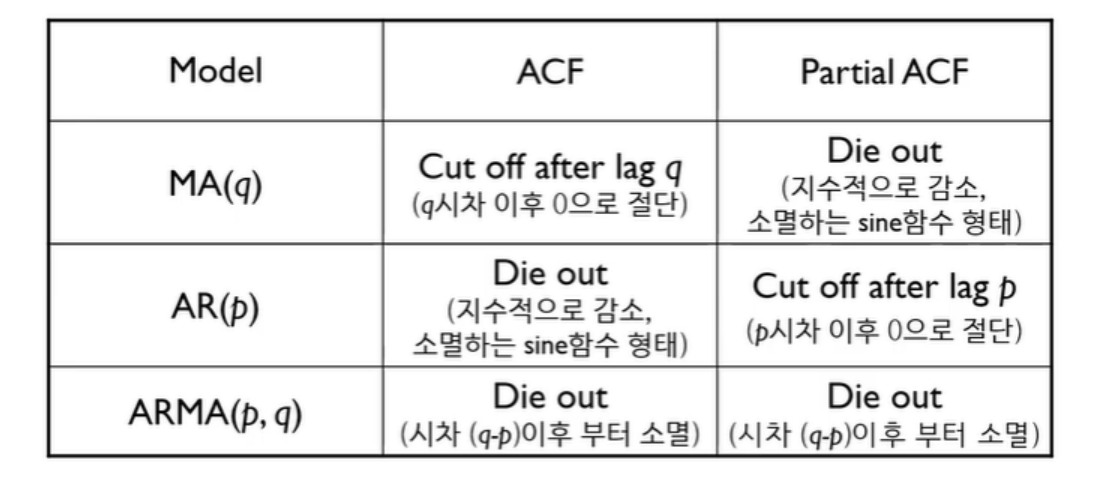

### stationary한 데이터이기 때문에 Differencing을 수행하지 않고 넘어감

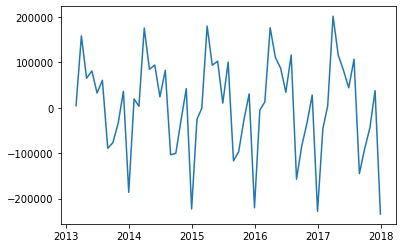

In [123]:
### unstationary한 데이터일 경우 Differnecing 수행해야함
diff_salesbymonth = salesbymonth.diff()
plt.plot(diff_salesbymonth)
# differencing을 수행할 경우 diff차수에 따른 NaN 데이터 생성 되기 떄문에 열로 DROP
diff_salesbymonth.dropna(axis = 0, inplace = True)

C:\Users\rlawo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


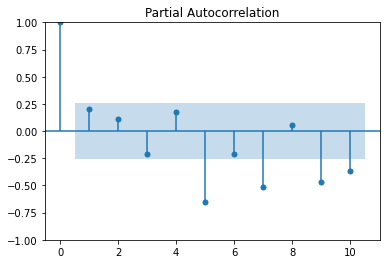

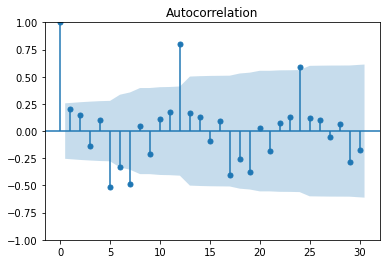

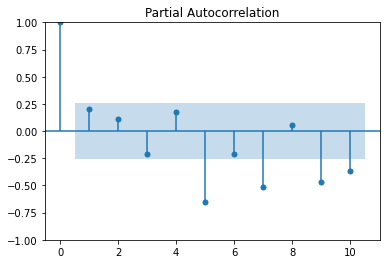

In [125]:
#Differencing 후의 ACF, P_ACF 그래프 확인
sm.graphics.tsa.plot_acf(diff_salesbymonth, lags=30)
sm.graphics.tsa.plot_pacf(diff_salesbymonth, lags = 10)

## ACF가 Die out, PACF가 Cut off after 1의 형태를 가지므로 AR모델을 활용
## ARIMA(1,1,0)
## 데이터가 Sesonal한 특성을 가지고 있기때문에 Seasonal ARIMA 모델 활용

In [140]:
model = SARIMAX(salesbymonth.values, order = (1,1,0), seasonal_order=(1,1,0,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -517.556
Date:                            Thu, 26 May 2022   AIC                           1041.111
Time:                                    21:41:59   BIC                           1046.662
Sample:                                         0   HQIC                          1043.200
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0041      0.128     -0.032      0.974      -0.255       0.247
ar.S.L12       0.1198      0.062      1.920      0.055      -0.002       0.242
sigma2      2.956e+08   2.62e-11   1.13e+19      0.000    2.96e+08    2.96e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.04   Jarque-Bera (JB):                 5.69
Prob(Q):                              0.15   Prob(JB):                         0.06
Heteroskedasticity (H):               2.95   Skew:                            -0.65
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.43e+34. Standard errors may be unstable.
"""

In [141]:
# 모델을 통해 30 Month의 sales값 예측
pred = model_fit.forecast(30)

In [144]:
# 이후 DATE 생성
date= pd.date_range('2018-01-31', periods=len(pred), freq='M')
preddf=pd.DataFrame(date)
for i in range(0,len(pred)) :
    preddf['sales'] = pred
# DATE의 값을 index로 설정
preddf.set_index(0).head(5)

,sales
0,
2018-01-31,6.441767e+05
2018-02-28,6.472269e+05
2018-03-31,8.515641e+05
2018-04-30,9.683731e+05
2018-05-31,1.049603e+06


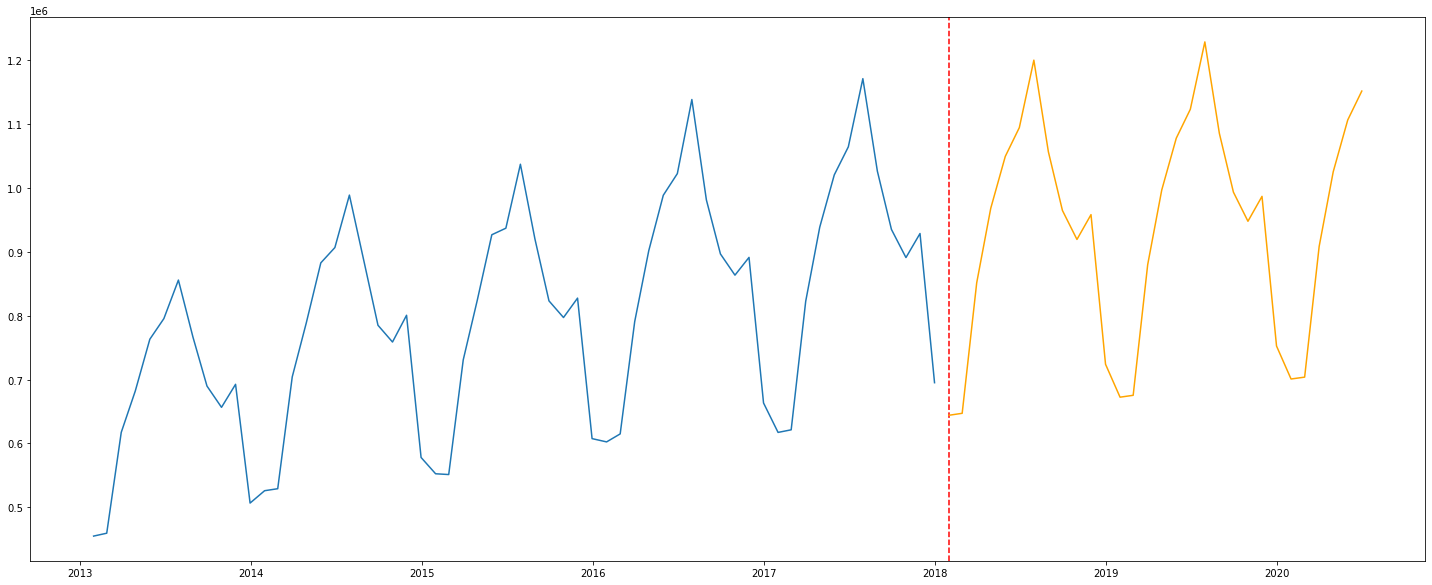

In [145]:
plt.figure(figsize = (25,10))
plt.plot(salesbymonth)
plt.axvline(x=datetime(2018, 1, 31), color='r', linestyle='--')
plt.plot(preddf[0],preddf['sales'], "orange")
plt.show()